# Analytical uncertainty at CO<sub>2</sub> measurement stations

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from collections import OrderedDict
import numpy as np
import pandas as pd
import xarray as xr
xr.set_options(display_style='text')

import matplotlib.pyplot as plt

import figure_panels
import obs_surface
import util

## Load the monthly data

Specify the records at each station to examine.

In [3]:
stn_records = dict(
    SPO=[
        'SPO_NOAA_insitu_CO2',
        'SPO_NOAA_flask_CO2',
        'SPO_SIO_O2_flask_CO2',
        'SPO_CSIRO_flask_CO2',
        'SPO_SIO_CDK_flask_CO2',    
    ],
    CGO=[
        'CGO_CSIRO_insitu_CO2',
        'CGO_NOAA_flask_CO2',
        'CGO_CSIRO_flask_CO2',
        'CGO_SIO_O2_flask_CO2',
    ],
)
record_list = [ri for r in stn_records.values() for ri in r]

1. Read txt file containing the station data.
1. Make all records into a dataset for later plotting.
1. Compute mean across records at each station and generate "anomaly" columns.

In [4]:
# generate column names for the "anomaly" columns (minus station mean)
stn_records_a = dict()
for stn, records in stn_records.items():
    stn_records_a[stn] = [f'{rec}_mmedian' for rec in records]
    
# read monthly data
file = obs_surface.data_files('CO2', 'obs')
df = obs_surface.read_stndata(file)

# get dataset
stninfo = obs_surface.get_stn_info('CO2')
ds = obs_surface.to_dataset(
    stninfo, df, 'CO2', 
    plot_coverage=False, 
    dropna=False, 
    unique_stn=False, 
    gap_fill=False).to_dataset()

# keep only columns from stations specified above
df = df[filter(lambda s: '_CO2' in s and 
               any(s in records for records in stn_records.values()) 
               or '_CO2' not in s, df.columns)]

# compute station median and add as new columns
for (stn, arecords), records in zip(stn_records_a.items(), stn_records.values()):
    df[stn] = df[records].median(axis=1)
    df[arecords] = df[records].sub(df[stn], axis=0)
df

year  month   day    year_frac  polar_year  SPO_SIO_CDK_flask_CO2  \
date                                                                            
1998-12-15  1998     12  15.5  1998.956164        1999               365.0013   
1999-01-15  1999      1  15.5  1999.041096        1999               364.9615   
1999-02-14  1999      2  14.0  1999.123288        1999               364.7820   
1999-03-15  1999      3  15.5  1999.202740        1999               364.8418   
1999-04-15  1999      4  15.0  1999.287671        1999               365.0213   
...          ...    ...   ...          ...         ...                    ...   
2019-10-15  2019     10  15.5  2019.789041        2020               408.8537   
2019-11-15  2019     11  15.0  2019.873973        2020               408.8636   
2019-12-15  2019     12  15.5  2019.956164        2020               409.0132   
2020-01-15  2020      1  15.5  2020.040984        2020               408.8138   
2020-02-14  2020      2  14.5  2020.122951        2020               408.7241   

            SPO_NOAA_insitu_CO2  CGO_NOAA_flask_CO2  CGO_CSIRO_insitu_CO2  \
date                                                                        
1998-12-15             365.0870            364.9250                   NaN   
1999-01-15             365.0233            364.9575                   NaN   
1999-02-14             364.9477            365.0900                   NaN   
1999-03-15             364.8559            364.8880                   NaN   
1999-04-15             365.0247            364.9900                   NaN   
...                         ...                 ...                   ...   
2019-10-15             408.8633            408.6825              408.8186   
2019-11-15             408.9070            408.8037              408.7658   
2019-12-15             408.8532            408.5017              408.5183   
2020-01-15                  NaN                 NaN                   NaN   
2020-02-14                  NaN                 NaN                   NaN   

            CGO_CSIRO_flask_CO2  ...  SPO_NOAA_insitu_CO2_mmedian  \
date                             ...                                
1998-12-15             364.8809  ...                     -0.00205   
1999-01-15             364.9474  ...                     -0.06450   
1999-02-14             365.1991  ...                     -0.01380   
1999-03-15             364.8469  ...                     -0.01580   
1999-04-15             365.0387  ...                      0.00000   
...                         ...  ...                          ...   
2019-10-15             408.6942  ...                      0.00960   
2019-11-15             408.7523  ...                      0.04340   
2019-12-15             408.6873  ...                     -0.08780   
2020-01-15                  NaN  ...                          NaN   
2020-02-14                  NaN  ...                          NaN   

            SPO_NOAA_flask_CO2_mmedian  SPO_SIO_O2_flask_CO2_mmedian  \
date                                                                   
1998-12-15                     0.04095                       0.00205   
1999-01-15                     0.09930                       0.00000   
1999-02-14                     0.08050                       0.00000   
1999-03-15                     0.20000                       0.00000   
1999-04-15                     0.11780                       0.03150   
...                                ...                           ...   
2019-10-15                     0.00460                      -0.13460   
2019-11-15                     0.01640                      -0.10470   
2019-12-15                     0.05650                      -0.08230   
2020-01-15                         NaN                      -0.04985   
2020-02-14                         NaN                      -0.18450   

            SPO_CSIRO_flask_CO2_mmedian  SPO_SIO_CDK_flask_CO2_mmedian  \
date                                           

## Compute the long-term standard deviation of monthly records

In [5]:
print('Long-term std dev of monthly records:')
for stn, records in stn_records_a.items():
    print(f'{stn}: {np.nanstd(df[records].values):0.4f}')

Long-term std dev of monthly records:
SPO: 0.1269
CGO: 0.1077


## Compute seasonal means

Loop over the seasons and generate seasonal averages. 

Require at least 2 months to define a season.

In [6]:
seasons = OrderedDict([
    ('djf', [12, 1, 2]),
    ('mam', [3, 4, 5]),
    ('jja', [6, 7, 8]),
    ('son', [9, 10, 11]),
])
dfs_seasons = {}
for season, months in seasons.items():
    if season == 'djf':
        groupby_col = 'polar_year'
        drop_cols = ['month', 'day', 'year']        
    else:
        groupby_col = 'year'
        drop_cols = ['month', 'day', 'polar_year']

    grouped = df.loc[df.month.isin(months)].groupby(groupby_col)
    
    dfs_seasons[season] = grouped.mean().where(grouped.count()>=2)
    dfs_seasons[season] = dfs_seasons[season].set_index('year_frac')
    dfs_seasons[season] = dfs_seasons[season].drop(drop_cols, axis=1)
    
dfs_seasons['son']

SPO_SIO_CDK_flask_CO2  SPO_NOAA_insitu_CO2  CGO_NOAA_flask_CO2  \
year_frac                                                                     
1999.789954             366.546833           366.652033          366.485433   
2000.790528             367.783267           367.886567          367.676267   
2001.789954             369.528167           369.798500          369.552500   
2002.789954             371.808200           371.996267          371.783767   
2003.789954             373.815700           374.085800          373.887233   
2004.790528             375.593833           375.713767          375.600400   
2005.789954             377.834000           377.916767          377.713633   
2006.789954             379.322967           379.542000          379.468500   
2007.789954             381.619633           381.748333          381.553600   
2008.790528             383.354567           383.635400          383.582100   
2009.789954             384.973200           385.131367          385.073333   
2010.789954             387.313067           387.412467          387.400000   
2011.789954             388.991500           389.038333          388.994467   
2012.790528             391.231667           391.335700          391.220400   
2013.789954             393.986967           393.999967          393.814733   
2014.789954             395.954567           395.908433          395.725000   
2015.789954             398.563600           398.430967          398.469833   
2016.790528             401.810833           401.629667          401.493333   
2017.789954             403.589000           403.638500          403.447533   
2018.789954             406.291133           406.126200          406.021667   
2019.789954             408.820433           408.828767          408.737400   

             CGO_CSIRO_insitu_CO2  CGO_CSIRO_flask_CO2  SPO_CSIRO_flask_CO2  \
year_frac                                                                     
1999.789954                   NaN           366.551133           366.622667   
2000.790528                   NaN           367.733767           367.693000   
2001.789954                   NaN           369.554000           369.600500   
2002.789954                   NaN           371.837167           371.861000   
2003.789954                   NaN           373.939467           373.976000   
2004.790528            375.657567           375.692033           375.832500   
2005.789954            377.874400           377.910333           377.801500   
2006.789954            379.442533           379.405733           379.590500   
2007.789954            381.721733           381.596667                  NaN   
2008.790528            383.584767           383.613233                  NaN   
2009.789954            385.161800           385.063833                  NaN   
2010.789954            387.370700           387.334433           387.382000   
2011.789954            388.987867           388.984233           388.916333   
2012.790528            391.239667           391.290533                  NaN   
2013.789954            393.928567           393.901033           394.091000   
2014.789954            395.804000           395.841600           396.073667   
2015.789954            398.406500           398.446767           398.569667   
2016.790528            401.538233           401.521000           401.779333   
2017.789954            403.673933           403.625500           403.517000   
2018.789954            405.938500           405.995100           406.003000   
2019.789954            408.761267           408.726200           408.712333   

             CGO_SIO_O2_flask_CO2  SPO_SIO_O2_flask_CO2  SPO_NOAA_flask_CO2  \
year_frac                                                                     
1999.789954            366.157433            366.636567          366.635833   
2000.790528            367.617033            367.929467          367.738800   
2001.789954            369.451733            369.716500      

## Long-term seasonal means

In [7]:
# make list of *all* records
records = [record for stn, records in stn_records_a.items() for record in records]

# dimension dictionary with lists
df_mean = {'season': list(seasons.keys())}
df_mean.update({r: [] for r in records})

# loop over seasons, compute long-term mean
for season in seasons:
    for r in records:
        df_mean[r].append(dfs_seasons[season][r].mean(axis=0))
df_mean = pd.DataFrame(df_mean).set_index('season')
df_mean

SPO_NOAA_insitu_CO2_mmedian  SPO_NOAA_flask_CO2_mmedian  \
season                                                            
djf                       -0.017290                    0.024567   
mam                        0.039309                    0.006748   
jja                        0.067344                   -0.003321   
son                        0.021917                    0.021340   

        SPO_SIO_O2_flask_CO2_mmedian  SPO_CSIRO_flask_CO2_mmedian  \
season                                                              
djf                        -0.004355                     0.106728   
mam                        -0.035228                    -0.040449   
jja                        -0.036373                    -0.078673   
son                        -0.005043                    -0.016149   

        SPO_SIO_CDK_flask_CO2_mmedian  CGO_CSIRO_insitu_CO2_mmedian  \
season                                                                
djf                         -0.056947                      0.004599   
mam                         -0.001835                      0.061413   
jja                          0.015745                      0.032955   
son                         -0.058767                      0.043461   

        CGO_NOAA_flask_CO2_mmedian  CGO_CSIRO_flask_CO2_mmedian  \
season                                                            
djf                       0.027571                     0.007436   
mam                      -0.005066                    -0.009310   
jja                       0.004226                    -0.000957   
son                      -0.004791                     0.037020   

        CGO_SIO_O2_flask_CO2_mmedian  
season                                
djf                        -0.068187  
mam                        -0.039366  
jja                        -0.056112  
son                        -0.118329

## SD of the long-term mean at each station

In [8]:
error = {'season': list(seasons.keys())}
error.update({stn: [] for stn in stn_records.keys()})
for stn, arecords in stn_records_a.items():
    for season in seasons:
        error[stn].append(df_mean.loc[season][arecords].std(ddof=1))

df_error = pd.DataFrame(error).set_index('season')
df_error

SPO       CGO
season                    
djf     0.061237  0.041960
mam     0.032685  0.042500
jja     0.054904  0.037213
son     0.033189  0.074899

## Median across records at SPO and CGO

In [9]:
ds_mSPO_med = (ds.sel(record=stn_records['SPO']) - ds.sel(record=stn_records['SPO']).median('record', skipna=True))
ds_mCGO_med = (ds.sel(record=stn_records['CGO']) - ds.sel(record=stn_records['CGO']).median('record', skipna=True))
ds_m_med = xr.concat((ds_mSPO_med, ds_mCGO_med), 'record')
ds_m_med.record

<xarray.DataArray 'record' (record: 9)>
array(['SPO_NOAA_insitu_CO2', 'SPO_NOAA_flask_CO2', 'SPO_SIO_O2_flask_CO2',
       'SPO_CSIRO_flask_CO2', 'SPO_SIO_CDK_flask_CO2', 'CGO_CSIRO_insitu_CO2',
       'CGO_NOAA_flask_CO2', 'CGO_CSIRO_flask_CO2', 'CGO_SIO_O2_flask_CO2'],
      dtype=object)
Coordinates:
  * record       (record) object 'SPO_NOAA_insitu_CO2' ... 'CGO_SIO_O2_flask_...
    institution  (record) object 'NOAA' 'NOAA' 'SIO_O2' ... 'CSIRO' 'SIO_O2'
    lat          (record) float64 -89.98 -89.98 -89.98 ... -40.68 -40.68 -40.68
    lon          (record) float64 -24.8 -24.8 -24.8 -24.8 ... 144.7 144.7 144.7
    stncode      (record) object 'SPO' 'SPO' 'SPO' 'SPO' ... 'CGO' 'CGO' 'CGO'

## Seasonal means of the medians

In [10]:
ds_djf = util.ann_mean(ds_m_med, season='DJF', time_bnds_varname=None, n_req=2,)
ds_jja = util.ann_mean(ds_m_med, season='JJA', time_bnds_varname=None, n_req=2,)

ds_djf.time

<xarray.DataArray 'time' (time: 22)>
array([1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010,
       2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020])
Coordinates:
  * time     (time) int64 1999 2000 2001 2002 2003 ... 2016 2017 2018 2019 2020

## Time series of SPO and CGO records

<Figure size 432x576 with 0 Axes>

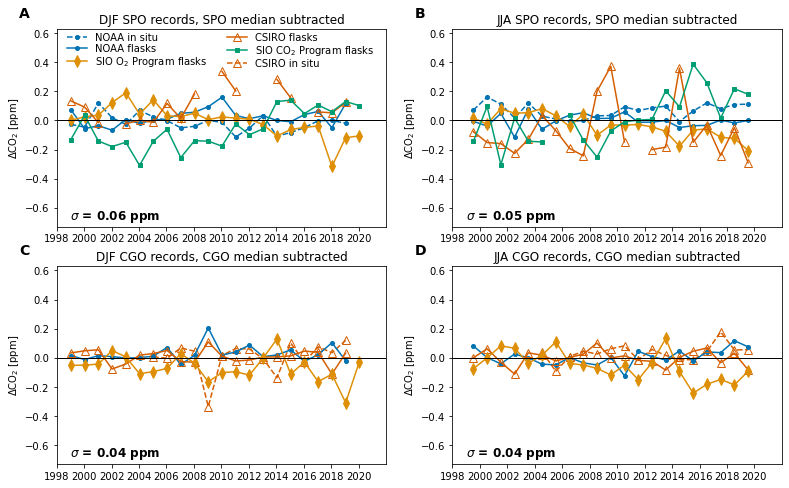

In [11]:
fig = plt.figure(figsize=(6, 8))

ncol = 2
nrow = 2
fig, axs = plt.subplots(nrow, ncol, figsize=(6.5*ncol, 4*nrow))   

marker_spec = figure_panels.marker_spec_co2_inst()

labels = dict(
    SPO_NOAA_insitu_CO2='NOAA in situ',
    SPO_NOAA_flask_CO2='NOAA flasks',
    SPO_SIO_O2_flask_CO2='SIO O$_2$ Program flasks',
    SPO_SIO_CDK_flask_CO2='SIO CO$_2$ Program flasks',
    SPO_CSIRO_flask_CO2='CSIRO flasks',
    CGO_NOAA_flask_CO2='NOAA flasks',
    CGO_SIO_O2_flask_CO2='SIO O$_2$ Program flasks',
    CGO_CSIRO_flask_CO2='CSIRO flasks',
    CGO_CSIRO_insitu_CO2='CSIRO in situ',
)

def ammendments(ax):
    ax.axhline(0, color='k', lw=1);
    ax.set_ylabel('$\Delta$CO$_2$ [ppm]')    
    ax.set_xticks(np.arange(1998, 2022, 2));
    ax.set_xlim([1998, 2022])
    ax.set_ylim([-0.73, 0.63]);

plotted_elements = []
legend_elements = []
    
    
dset = ds_djf.CO2.sel(record=record_list).copy()
# for stn in ['SPO', 'CGO']:
#     idx = np.where(dset.stncode == stn)[0]
#     dset[:, idx] = dset[:, idx]


x = dset.time + util.season_yearfrac['DJF']
for i, record in enumerate(dset.record.values):    
    ax = axs[0, 0] if 'SPO' in record else axs[1, 0]
    y = dset.sel(record=record)
    ls = '--' if 'insitu' in record else '-'
        
    inst = str(dset.sel(record=record).institution.values)
    p = ax.plot(x, y, linestyle=ls, label=labels[record], **marker_spec[inst])
    if labels[record] not in plotted_elements:
        legend_elements.append(p[0])
        plotted_elements.append(labels[record])


dset = ds_jja.CO2.sel(record=record_list).copy()
# for stn in ['SPO', 'CGO']:
#     idx = np.where(dset.stncode == stn)[0]
#     dset[:, idx] = dset[:, idx]


x = dset.time + util.season_yearfrac['JJA']
for i, record in enumerate(dset.record.values):
    ax = axs[0, 1] if 'SPO' in record else axs[1, 1]
    y = dset.sel(record=record)
    ls = '--' if 'insitu' in record else '-'
    inst = str(dset.sel(record=record).institution.values)    
    p = ax.plot(x, y, linestyle=ls, label=labels[record], **marker_spec[inst])
    if labels[record] not in plotted_elements:
        legend_elements.append(p[0])
        plotted_elements.append(labels[record])

for ax in axs.ravel():
    ammendments(ax)

    
xoff = 1
yoff = 0.05
str_text = f'$\sigma$ = {df_error.loc["djf"].SPO:0.2f} ppm'
axs[0, 0].text(ax.get_xlim()[0]+xoff, ax.get_ylim()[0]+yoff, 
        str_text, fontsize=12, fontweight='bold',
       )

str_text = f'$\sigma$ = {df_error.loc["djf"].CGO:0.2f} ppm'
axs[1, 0].text(ax.get_xlim()[0]+xoff, ax.get_ylim()[0]+yoff, 
        str_text, fontsize=12, fontweight='bold',
       )

str_text = f'$\sigma$ = {df_error.loc["jja"].SPO:0.2f} ppm'
axs[0, 1].text(ax.get_xlim()[0]+xoff, ax.get_ylim()[0]+yoff, 
        str_text, fontsize=12, fontweight='bold',
       )

str_text = f'$\sigma$ = {df_error.loc["jja"].CGO:0.2f} ppm'
axs[1, 1].text(ax.get_xlim()[0]+xoff, ax.get_ylim()[0]+yoff, 
        str_text, fontsize=12, fontweight='bold',
       )    
          
axs[0, 0].set_title('DJF SPO records, SPO median subtracted')
axs[1, 0].set_title('DJF CGO records, CGO median subtracted')


axs[0, 1].set_title('JJA SPO records, SPO median subtracted')
axs[1, 1].set_title('JJA CGO records, CGO median subtracted')

util.label_plots(fig, [ax for ax in axs.ravel()])

axs[0, 0].legend(handles=legend_elements, ncol=2, loc=(0.02, 0.78), frameon=False, labelspacing=0.1)

util.savefig('SPO-CGO-record-discrepancies')